# Install tensorflow package
!pip install tensorflow

# Install package to work with images
!pip install Pillow

In [11]:
import os

breeds = ["beagle", "bernese_mountain_dog", "doberman", "labrador_retriever", "siberian_husky"]

In [12]:
import tensorflow as tf

In [13]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": breeds
}

train = tf.keras.utils.image_dataset_from_directory(
    "images",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "images",
  subset="validation",
    **args
)


Found 928 files belonging to 5 classes.
Using 743 files for training.
Found 928 files belonging to 5 classes.
Using 185 files for validation.


In [14]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [15]:
first = train.take(1)
first

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [16]:
images, labels = list(first)[0]
print(images[0])

tf.Tensor(
[[[171.2928   174.2928    83.2928  ]
  [174.20525  177.20525   86.205246]
  [169.91797  172.91797   81.91797 ]
  ...
  [172.88504  177.79417   83.53552 ]
  [171.94514  180.15039   74.86914 ]
  [171.03983  180.03983   75.039825]]

 [[172.83153  176.73387   85.2827  ]
  [172.05714  175.95949   84.508316]
  [172.13533  176.03767   84.5865  ]
  ...
  [170.28123  175.68832   80.45395 ]
  [173.58934  182.15965   76.8784  ]
  [171.64503  180.64503   75.645035]]

 [[169.86151  174.86151   82.86151 ]
  [162.98438  167.98438   75.984375]
  [171.94905  176.94905   84.94905 ]
  ...
  [177.10622  183.01126   86.27298 ]
  [176.5039   185.07422   79.79297 ]
  [172.78804  181.78804   76.78804 ]]

 ...

 [[129.07872  131.94098   50.373642]
  [145.22093  149.15453   60.75023 ]
  [146.50914  151.39586   56.60875 ]
  ...
  [156.0894   166.80453   64.59331 ]
  [132.7068   146.41774   45.351334]
  [101.41571  116.05736   19.814621]]

 [[162.7798   163.7798    85.92433 ]
  [147.2745   149.7042    

In [17]:
print(labels[0])

tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


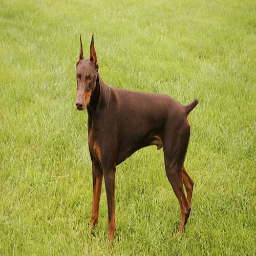

In [18]:
from PIL import Image

Image.fromarray(images[0].numpy().astype("uint8"))

In [19]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(breeds))
])


In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
history = model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)

Epoch 1/5


2022-04-10 10:32:15.729381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-10 10:32:16.335847: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-10 10:32:16.395386: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - 2s 37ms/step - loss: 46.2241 - accuracy: 0.2275 - val_loss: 3.3149 - val_accuracy: 0.2486
Epoch 2/5
24/24 [==============================] - 1s 26ms/step - loss: 1.9594 - accuracy: 0.3607 - val_loss: 1.6045 - val_accuracy: 0.3676
Epoch 3/5
24/24 [==============================] - 1s 26ms/step - loss: 1.1877 - accuracy: 0.5882 - val_loss: 1.6249 - val_accuracy: 0.3189
Epoch 4/5
24/24 [==============================] - 1s 26ms/step - loss: 0.7518 - accuracy: 0.8210 - val_loss: 1.7000 - val_accuracy: 0.3081
Epoch 5/5
24/24 [==============================] - 1s 26ms/step - loss: 0.3652 - accuracy: 0.9596 - val_loss: 1.7478 - val_accuracy: 0.3243


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 134,218,949
Trainable params: 134,218,949
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

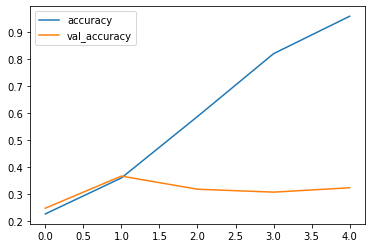

In [24]:
import pandas as pd

history_df = pd.DataFrame.from_dict(history.history)
history_df[["accuracy", "val_accuracy"]].plot()

In [25]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [26]:
network = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(breeds))
]

history_df, model = train_model(network)

Epoch 1/5
24/24 [==============================] - 1s 30ms/step - loss: 1.9257 - accuracy: 0.2153 - val_loss: 1.5990 - val_accuracy: 0.2432
Epoch 2/5
24/24 [==============================] - 0s 21ms/step - loss: 1.5808 - accuracy: 0.2598 - val_loss: 1.5336 - val_accuracy: 0.3243
Epoch 3/5
24/24 [==============================] - 0s 21ms/step - loss: 1.4553 - accuracy: 0.3567 - val_loss: 1.5303 - val_accuracy: 0.3135
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 1.2574 - accuracy: 0.4832 - val_loss: 1.6140 - val_accuracy: 0.3189
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 0.9394 - accuracy: 0.6581 - val_loss: 1.8623 - val_accuracy: 0.2973


<AxesSubplot:>

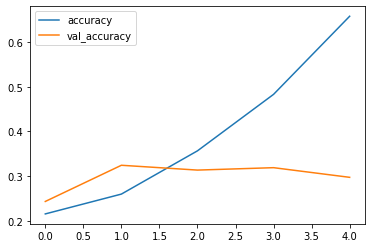

In [27]:
history_df[["accuracy", "val_accuracy"]].plot()

In [38]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)


full_network = [
    data_augmentation
] + network

history_df, model = train_model(full_network, epochs=10)

Epoch 1/10
24/24 [==============================] - 1s 26ms/step - loss: 1.3796 - accuracy: 0.4764 - val_loss: 1.4311 - val_accuracy: 0.4054
Epoch 2/10
24/24 [==============================] - 1s 22ms/step - loss: 1.2691 - accuracy: 0.4993 - val_loss: 1.4084 - val_accuracy: 0.4486
Epoch 3/10
24/24 [==============================] - 1s 23ms/step - loss: 1.1969 - accuracy: 0.5249 - val_loss: 1.3951 - val_accuracy: 0.4108
Epoch 4/10
24/24 [==============================] - 1s 23ms/step - loss: 1.1613 - accuracy: 0.5343 - val_loss: 1.3589 - val_accuracy: 0.4324
Epoch 5/10
24/24 [==============================] - 1s 23ms/step - loss: 1.1159 - accuracy: 0.5734 - val_loss: 1.3416 - val_accuracy: 0.4703
Epoch 6/10
24/24 [==============================] - 1s 23ms/step - loss: 1.0704 - accuracy: 0.5814 - val_loss: 1.3486 - val_accuracy: 0.4973
Epoch 7/10
24/24 [==============================] - 1s 23ms/step - loss: 1.0806 - accuracy: 0.5868 - val_loss: 1.3594 - val_accuracy: 0.4757
Epoch 8/10
24

<AxesSubplot:>

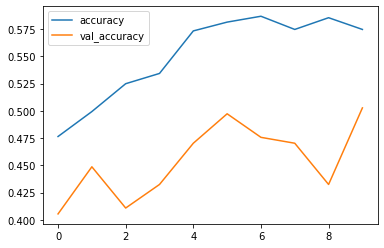

In [39]:
history_df[["accuracy", "val_accuracy"]].plot()

In [40]:
preds = model.predict(test)

In [41]:
predicted_class = np.argmax(preds, axis=1)

In [42]:
actual_labels = np.concatenate([y for x, y in test], axis=0)

In [43]:
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [44]:
actual_class = np.argmax(actual_labels, axis=1)

In [45]:
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

In [46]:
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: breeds[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: breeds[x])

,prediction,actual,image
0,siberian_husky,siberian_husky,
1,bernese_mountain_dog,bernese_mountain_dog,
2,siberian_husky,labrador_retriever,
3,labrador_retriever,labrador_retriever,
4,beagle,beagle,
5,siberian_husky,labrador_retriever,
6,doberman,doberman,
7,labrador_retriever,doberman,
8,doberman,doberman,
9,bernese_mountain_dog,bernese_mountain_dog,

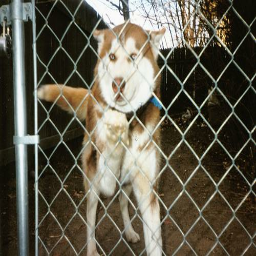
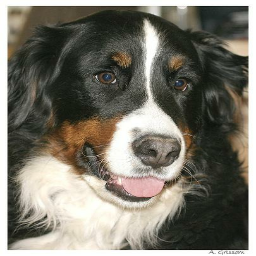
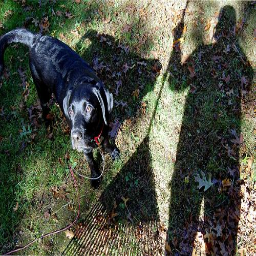
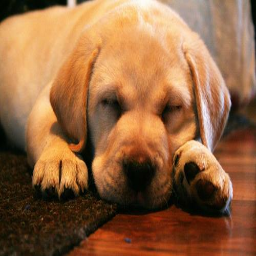
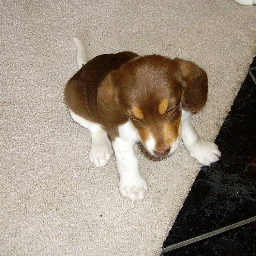
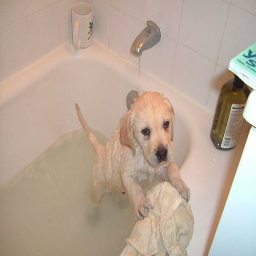
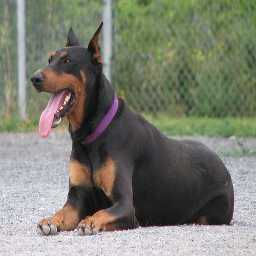
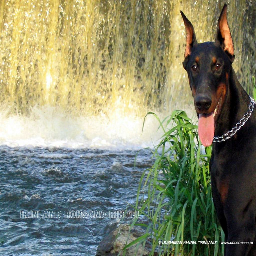
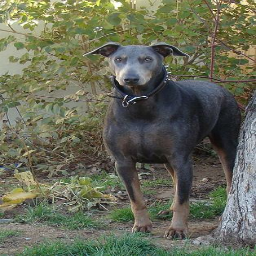
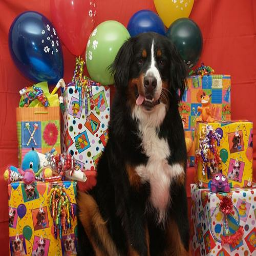

In [47]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head(10).style.format({'image': image_formatter})